# 00. Load packages

In [1]:
from sklearn.metrics import confusion_matrix

import os
from collections import Counter
import random

from tqdm import tqdm

import pandas as pds
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sbn

df = pds.read_csv(os.path.join('../files/Week 10. data-student.csv')
                  , delimiter=';'
                 )
print(df.shape)
Y = df['Target']
X = df.drop(columns = ['Target'], axis = 1)

Y.value_counts()

(4424, 37)


Graduate    2209
Dropout     1421
Enrolled     794
Name: Target, dtype: int64

In [2]:
Y = Y.apply(lambda x: 0 if x == 'Graduate' else (1 if x == 'Enrolled' else 2 ))

In [3]:
for c, sdf in X.iteritems():
    print(c, len(np.unique(sdf)), sdf.dtypes)

Marital status 6 int64
Application mode 18 int64
Application order 8 int64
Course 17 int64
Daytime/evening attendance	 2 int64
Previous qualification 17 int64
Previous qualification (grade) 101 float64
Nacionality 21 int64
Mother's qualification 29 int64
Father's qualification 34 int64
Mother's occupation 32 int64
Father's occupation 46 int64
Admission grade 620 float64
Displaced 2 int64
Educational special needs 2 int64
Debtor 2 int64
Tuition fees up to date 2 int64
Gender 2 int64
Scholarship holder 2 int64
Age at enrollment 46 int64
International 2 int64
Curricular units 1st sem (credited) 21 int64
Curricular units 1st sem (enrolled) 23 int64
Curricular units 1st sem (evaluations) 35 int64
Curricular units 1st sem (approved) 23 int64
Curricular units 1st sem (grade) 805 float64
Curricular units 1st sem (without evaluations) 11 int64
Curricular units 2nd sem (credited) 19 int64
Curricular units 2nd sem (enrolled) 22 int64
Curricular units 2nd sem (evaluations) 30 int64
Curricular unit

In [4]:
for c, sdf in X.iteritems():
    if sdf.dtypes == np.float64:
        print(c, len(np.unique(sdf)), sdf.dtypes)

Previous qualification (grade) 101 float64
Admission grade 620 float64
Curricular units 1st sem (grade) 805 float64
Curricular units 2nd sem (grade) 786 float64
Unemployment rate 10 float64
Inflation rate 9 float64
GDP 10 float64


# 01. Preprocessing


1. Remove columns

   데이터의 열에 단 하나의 값만 존재한다면, 해당 열의 사용 여부에 대해 고민해야 합니다.  
   버섯 데이터셋에 이런 경우가 존재한다면 제거하도록 코드를 작성하겠습니다.


2. Categorical columns

   데이터셋에 discrete value가 소수만 존재하는 경우, 동시에 value 간의 우위를 논하기 어려운 경우입니다.  
   One-hot encoding은 해당 데이터를 처리하기 위해 자주 사용되는 방법 중 하나입니다.


3. Numerical columns

   데이터의 열에 수치형 변수가 들어가 있는 경우입니다.  
   거리 기반의 기계학습 모델들을 활용하는 경우, numerical variable에 대한 normalization을 반드시 고려해줘야 합니다. 



In [5]:
from sklearn.tree import DecisionTreeClassifier

from itertools import product
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

In [6]:

remove_columns = []
categorical_columns = []
numerical_columns = []

# 열별로 데이터 탐색 진행 = column을 순차대로 탐색하는 것과 같음
for c, t in X.iteritems():
    
    # 데이터가 만약 수치형이 아니라면 categorical에 대해 고민해 볼 필요 있음
    if t.dtype != np.float64:
        
        # 데이터에 존재하는 고윳값 갯수 계산
        n_unique = len(t.unique())
        
        # 고윳값이 단 하나라면 필요 없는 데이터일수 있음
        if n_unique == 1:
            remove_columns.append(c)
            
        # 아니라면 categorical preprocessing 적용
        else:
            categorical_columns.append(c)
            
    # 수치형이라면, 수치형에 대한 preprocessing 적용 
    else:
        numerical_columns.append(c)

In [7]:
# dictionary comprehension

'''
위 아래 두 코드는 똑같이 작동하는 코드입니다.
'''

D = dict()
L = 'ABCELKTJEAT'
for n, s in enumerate(L):
    D[s] = n
print(D)

D = {s:n for n, s in enumerate(L)}
print(D)

{'A': 9, 'B': 1, 'C': 2, 'E': 8, 'L': 4, 'K': 5, 'T': 10, 'J': 7}
{'A': 9, 'B': 1, 'C': 2, 'E': 8, 'L': 4, 'K': 5, 'T': 10, 'J': 7}


In [8]:
for c, sdf in X.iteritems():
    if sdf.dtypes == np.int64:
        print(c, len(np.unique(sdf)), sdf.dtypes)

Marital status 6 int64
Application mode 18 int64
Application order 8 int64
Course 17 int64
Daytime/evening attendance	 2 int64
Previous qualification 17 int64
Nacionality 21 int64
Mother's qualification 29 int64
Father's qualification 34 int64
Mother's occupation 32 int64
Father's occupation 46 int64
Displaced 2 int64
Educational special needs 2 int64
Debtor 2 int64
Tuition fees up to date 2 int64
Gender 2 int64
Scholarship holder 2 int64
Age at enrollment 46 int64
International 2 int64
Curricular units 1st sem (credited) 21 int64
Curricular units 1st sem (enrolled) 23 int64
Curricular units 1st sem (evaluations) 35 int64
Curricular units 1st sem (approved) 23 int64
Curricular units 1st sem (without evaluations) 11 int64
Curricular units 2nd sem (credited) 19 int64
Curricular units 2nd sem (enrolled) 22 int64
Curricular units 2nd sem (evaluations) 30 int64
Curricular units 2nd sem (approved) 20 int64
Curricular units 2nd sem (without evaluations) 10 int64


In [9]:
def cat_transform(df, cs):
    return_list = []
    numeric_columns = []
    
    for c in cs:
        # categorical column list 'cs' 중 하나인 "c"에 존재하는 고윳 값들 전부에 대응되는 숫자 생성
        unique_values = {i : n for n,i in enumerate(sorted(df[c].unique()))}
        
        # lambda를 활용하여 dataframe의 c column에 존재하는 각 값들을 숫자로 변환
        num_df = df[c].apply(lambda x: unique_values[x])
        
        # 만약 고윳값이 2개인 경우, 1열로 표현 가능 ( e.g. 0 - 1 or -1 - 1 )
        if len(unique_values) == 2:
            return_list.append(num_df.values.reshape(-1,1))
        
        # 만약 고윳값이 3개 이상인 경우, 고윳값 갯수만큼의 열을 활용한 one-hot encoding을 수행해야 함.
        # 단 너무 많은 고윳값의 경우 discrete numerical variables일 수 있기 때문에, one-hot encoding에서 제외함
        elif len(unique_values) < 10:
            return_list.append(np.eye(len(unique_values))[num_df])

        # 제외한 column들을 return하여 numerical preprocessing을 적용
        else:
            numeric_columns.append(c)
    return np.concatenate(return_list, 1), numeric_columns


def num_transform(df, cs):
    num_df = df[cs].copy().values
    
    #열별 평균으로 빼고 분산을 1로 변환하는 Standard scaling (a.k.a z-scaling)
    num_df = (df[cs].values - num_df.mean(0)) / (num_df.std(0) + 1e-10)
    return num_df

In [10]:
remove_columns, categorical_columns, numerical_columns

([],
 ['Marital status',
  'Application mode',
  'Application order',
  'Course',
  'Daytime/evening attendance\t',
  'Previous qualification',
  'Nacionality',
  "Mother's qualification",
  "Father's qualification",
  "Mother's occupation",
  "Father's occupation",
  'Displaced',
  'Educational special needs',
  'Debtor',
  'Tuition fees up to date',
  'Gender',
  'Scholarship holder',
  'Age at enrollment',
  'International',
  'Curricular units 1st sem (credited)',
  'Curricular units 1st sem (enrolled)',
  'Curricular units 1st sem (evaluations)',
  'Curricular units 1st sem (approved)',
  'Curricular units 1st sem (without evaluations)',
  'Curricular units 2nd sem (credited)',
  'Curricular units 2nd sem (enrolled)',
  'Curricular units 2nd sem (evaluations)',
  'Curricular units 2nd sem (approved)',
  'Curricular units 2nd sem (without evaluations)'],
 ['Previous qualification (grade)',
  'Admission grade',
  'Curricular units 1st sem (grade)',
  'Curricular units 2nd sem (grade

In [13]:
cat_arr, add_numerical_columns = cat_transform(df, categorical_columns)

num_arr = num_transform(df, numerical_columns + add_numerical_columns)

df_arr = np.concatenate([num_arr, cat_arr], 1)

# 02. DT - regularization

In [11]:

def ss_kfold_fn(data_x, data_y, scaling = True):
    kf = StratifiedKFold()
    for n, (train_idx, valid_idx) in enumerate(kf.split(data_x, data_y)):
        
        scaler_x = StandardScaler()
        
        if scaling:
            
            train_x = scaler_x.fit_transform(data_x[train_idx])
            valid_x = scaler_x.transform(data_x[valid_idx])
            
        else:
            train_x = data_x[train_idx]
            valid_x = data_x[valid_idx]

        train_y = data_y[train_idx]
        valid_y = data_y[valid_idx]
        
        yield [
            [train_x, train_y],
            [valid_x, valid_y]
        ], (scaler_x)


In [14]:
g = ss_kfold_fn(df_arr, Y.values, False)

((train_x, train_y), (valid_x, valid_y)), s = next(g)

In [14]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from tqdm import tqdm
from multiprocessing import Pool

def dt_pred(ccpa):    
    dt = DecisionTreeClassifier(ccp_alpha = ccpa)
    dt.fit(train_x, train_y)
    return dt.predict_proba(valid_x)

ccp_range = np.arange(0, 3e-2, 1e-4)

if __name__ == '__main__':
    pool = Pool(3)
    logits = pool.map(dt_pred, ccp_range)
    pool.close()
    pool.join()


In [ ]:
accs = [accuracy_score(valid_y, l.argmax(1)) for l in logits]

f1s = [f1_score(valid_y, l.argmax(1), average = 'macro') for l in logits]

roc_aucs = [roc_auc_score(valid_y, l, multi_class = 'ovr') for l in logits]

fig,ax = plt.subplots(1,1, figsize = (10, 3))

ax.plot(ccp_range, accs)
ax.plot(ccp_range, f1s)
ax.plot(ccp_range, roc_aucs)

ax.legend(['ACC','F1','AUC'])

ax.set_title('Max score: ACC: {:.2f}% F1: {:.2f}% AUC: {:.4f}'.format(max(accs)*100, max(f1s)*100, max(roc_aucs)))
fig.show()

NameError: name 'logits' is not defined

# 03. Bagging


<figure>
    <img 
       src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbLHXE3%2Fbtqw7cWPjSb%2FxKoaC8GrwfFbAN2CMraSw0%2Fimg.png" 
       width="700">
</figure>
<br>


### 03-1. Split bagging datasets

In [15]:
from sklearn.neighbors import KNeighborsClassifier as KNC


In [16]:
def randomize_idx_and_col(x, y, bagging_ratio = .7):
    indexes, variables = x.shape
    
    bagging_indexes = int(indexes * bagging_ratio)
    bagging_variables = int(variables * bagging_ratio)
    
    random_idx = np.random.choice(range(indexes), bagging_indexes)
    random_col = np.random.choice(range(variables), bagging_variables)
    return (x[random_idx][:,random_col], y[random_idx]), (random_idx, random_col)  # part of full dataframe x

In [17]:
sub_train, sub_loc = randomize_idx_and_col(train_x, train_y)

### 03-2. Create bagging models

In [18]:
def model_generate(
    knn_neighbors = [3,7,13,21],
    knn_repeats = 3,
    dt_repeats = 30,
):
    models = []
    
    for n_neighbors in knn_neighbors:
        models.extend([KNC(n_neighbors = n_neighbors, n_jobs = -1, weights = 'distance')] * knn_repeats)
    models.extend([DecisionTreeClassifier()] * dt_repeats)
    return models

In [19]:
models = model_generate()

### 03-3.  Learning models with Bagging process

In [20]:
logits = []
for model in tqdm(models):
    sub_train, sub_loc = randomize_idx_and_col(train_x, train_y)
    model.fit(*sub_train)
    logits.append(model.predict_proba(valid_x[:, sub_loc[1]]))

100%|██████████| 42/42 [00:04<00:00, 10.02it/s]


C:\Users\keb20\AppData\Local\Temp/ipykernel_28612/3048448373.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


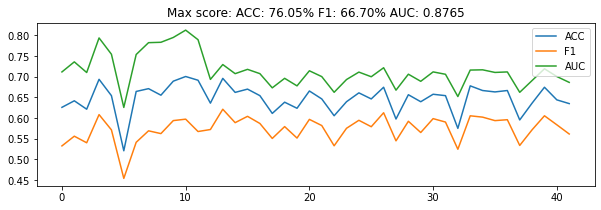

In [24]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
accs = [accuracy_score(valid_y, l.argmax(1)) for l in logits]

f1s = [f1_score(valid_y, l.argmax(1), average = 'macro') for l in logits]

roc_aucs = [roc_auc_score(valid_y, l, multi_class = 'ovr') for l in logits]

fig,ax = plt.subplots(1,1, figsize = (10, 3))

ax.plot(accs)
ax.plot(f1s)
ax.plot(roc_aucs)

ax.legend(['ACC','F1','AUC'])


avg_acc = accuracy_score(valid_y, np.array(logits).mean(0).argmax(-1))
avg_f1  = f1_score(valid_y, np.array(logits).mean(0).argmax(-1), average = 'macro')
avg_roc = roc_auc_score(valid_y, np.array(logits).mean(0), multi_class = 'ovr')

ax.set_title('Max score: ACC: {:.2f}% F1: {:.2f}% AUC: {:.4f}'.format(avg_acc*100, avg_f1*100, avg_roc))
fig.show()

# 04. Ensemble

In [25]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [26]:
from sklearn.ensemble import HistGradientBoostingClassifier as HGBC
from xgboost import XGBClassifier

In [27]:
ensemble = HGBC(max_iter=1000)

ensemble.fit(train_x, train_y)

ensemble_logit = ensemble.predict_proba(valid_x)

In [29]:
xgb = XGBClassifier(
    n_estimators = 100000,
    # gpu_id = 0,
    # tree_method = 'gpu_hist',
    learning_rate = 1e-2
)
xgb.fit(train_x, train_y, eval_set = [(valid_x, valid_y)], verbose = 1000, early_stopping_rounds = 1000)

xgb_logit = xgb.predict_proba(valid_x)

[0]	validation_0-mlogloss:1.09126
[1000]	validation_0-mlogloss:0.56111
[1739]	validation_0-mlogloss:0.59080


In [30]:
ensemble_acc = accuracy_score(valid_y, ensemble_logit.argmax(-1))
ensemble_f1 = f1_score(valid_y, ensemble_logit.argmax(-1), average = 'macro')
ensemble_auc = roc_auc_score(valid_y, ensemble_logit, multi_class = 'ovr')

xgb_acc = accuracy_score(valid_y, xgb_logit.argmax(-1))
xgb_f1 = f1_score(valid_y, xgb_logit.argmax(-1), average = 'macro')
xgb_auc = roc_auc_score(valid_y, xgb_logit, multi_class = 'ovr')

print('Reg. DT   ACC: {:.2f}% F1: {:.2f}% AUC: {:.4f}'.format(max(accs)*100, max(f1s)*100, max(roc_aucs)))
print('Bagging   ACC: {:.2f}% F1: {:.2f}% AUC: {:.4f}'.format(avg_acc*100, avg_f1*100, avg_roc))
print('Ensemble  ACC: {:.2f}% F1: {:.2f}% AUC: {:.4f}'.format(ensemble_acc*100, ensemble_f1*100, ensemble_auc))
print('XGBoost   ACC: {:.2f}% F1: {:.2f}% AUC: {:.4f}'.format(xgb_acc*100, xgb_f1*100, xgb_auc))

Reg. DT   ACC: 70.06% F1: 62.14% AUC: 0.8127
Bagging   ACC: 76.05% F1: 66.70% AUC: 0.8765
Ensemble  ACC: 75.59% F1: 67.25% AUC: 0.8796
XGBoost   ACC: 77.40% F1: 70.29% AUC: 0.8886
